### All-sky AME vs. IR Scatter Plots

In [2]:
%matplotlib inline
#from IPython.external import mathjax; mathjax.install_mathjax()
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import healpy.projector as pro
import astropy.io.fits as fits
from scipy.stats import gaussian_kde
import scipy
import pandas as pd
import pickle

In [4]:
with open('../Data/maps.pickle') as f:  # Python 3: open(..., 'rb')
    coords, planck_bb, planck_mw, phot, phot_modesub = pickle.load(f)
    
phot.head()
#planck_bb.head()
#planck_mw.head()
#coords.head()

,A9,D12,I12,W12,A18,D25,I25,D60,I60,A65,A90,D100,I100,D140,A140,A160,D240,P857,P545
0,NaN,1.083658,1.071264,0.018346,NaN,2.099690,2.142549,0.610734,0.598758,2.073384,1.688520,1.546775,1.529856,0.787866,2.403259,2.195928,0.991204,0.583666,0.258794
1,NaN,1.091430,1.045220,0.017045,NaN,2.119253,2.171547,0.690011,0.596552,1.928738,1.394335,1.506179,1.455086,3.546372,2.527890,2.874538,0.672390,0.620408,0.269439
2,NaN,1.093857,1.064194,0.012653,NaN,2.122237,2.159359,0.697645,0.596992,1.806098,1.456207,1.512805,1.544730,3.832097,2.485977,2.421713,0.951366,0.629106,0.272736
3,NaN,1.082492,1.066986,0.029448,NaN,2.092455,2.135687,0.612444,0.616380,2.072155,1.593516,1.554953,1.524600,0.697479,2.373043,2.408980,0.558173,0.612663,0.284378
4,NaN,1.086391,1.082960,0.003322,NaN,2.100158,2.150484,0.644721,0.611308,2.598172,1.715493,1.545120,1.503084,1.173915,2.235033,2.398738,1.534221,0.521117,0.238315


In [5]:
glatrange     = 10.0
glatrange_mid = 2.5
elatrange     = 10


gcut_l = np.where((abs(coords['glat']) < glatrange) & (abs(coords['elat']) > elatrange))
gcut_h = np.where((abs(coords['glat']) > glatrange) & (abs(coords['elat']) > elatrange))







In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler


### Setup the standard pipeline to apply to all the data:
allsky_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

phot_tr = pd.DataFrame(allsky_pipeline.fit_transform(phot),columns=phot.columns)
planck_bb_tr = pd.DataFrame(allsky_pipeline.fit_transform(planck_bb),columns=planck_bb.columns)
planck_mw_tr = pd.DataFrame(allsky_pipeline.fit_transform(planck_mw),columns=planck_mw.columns)


phot_corr = phot_tr.corr(method='spearman')
planck_bb_corr = planck_bb_tr.corr(method='spearman')
planck_mw_corr = planck_mw_tr.corr(method='spearman')


In [10]:
import seaborn as sb
phot_corr     = phot_tr.join(planck_mw_tr['AME']).corr(method='spearman')
phot_corr_lgl = phot_tr.join(planck_mw_tr['AME']).iloc[gcut_l].corr(method='spearman')
phot_corr_hgl = phot_tr.join(planck_mw_tr['AME']).iloc[gcut_h].corr(method='spearman')

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


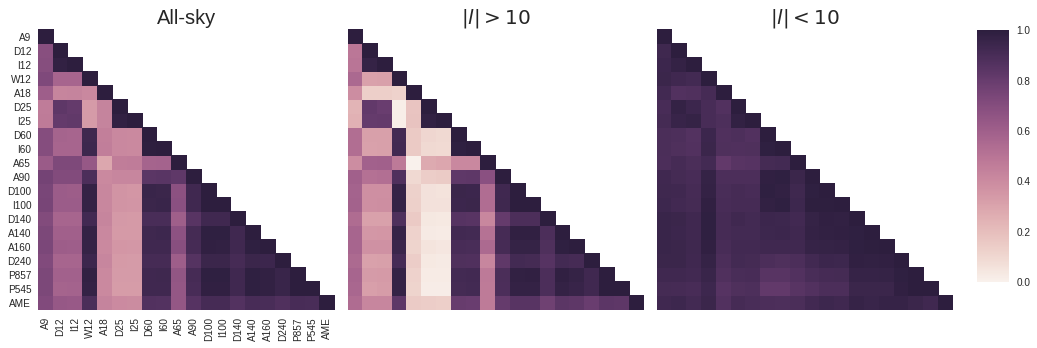

In [11]:
#bb_corr_drop = bb_corr.drop('AME',axis=0).drop('A9',axis=1)
mask = np.zeros_like(phot_corr.values)
mask[np.triu_indices_from(mask,k=1)] = True

with sb.axes_style("white"):

    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    cbar_ax = fig.add_axes([.91, .2, .03, .7])
    
    sb.heatmap(
        phot_corr,
        #linewidths=.5,
        annot=False,
        mask=mask,
        cbar=False,
        yticklabels=True,
        xticklabels=True,
        ax = ax[0],
        vmin=0,
        vmax=1)
    
    ax[0].set_title("All-sky", fontsize=20)

    
    sb.heatmap(
        phot_corr_hgl,
        #linewidths=.5,
        annot=False,
        mask=mask,
        cbar=False,
        yticklabels=False,
        xticklabels=False,
        ax=ax[1],
        vmin=0,
        vmax=1)
    
    ax[1].set_title("$|l| > 10$", fontsize=20)

    
    
    sb.heatmap(
        phot_corr_lgl,
        #linewidths=.5,
        annot=False,
        mask=mask,
        cbar=True,
        cbar_ax=cbar_ax,
        yticklabels=False,
        xticklabels=False,
        ax=ax[2],
        vmin=0,
        vmax=1)
    
    ax[2].set_title("$|l| < 10$", fontsize=20)


    fig.tight_layout(rect=[0, 0, .9, 1])
    
    plt.show()

    fig.savefig("../Plots/all_bands_corr_matrix_wAME_spearman.pdf", bbox_inches='tight')

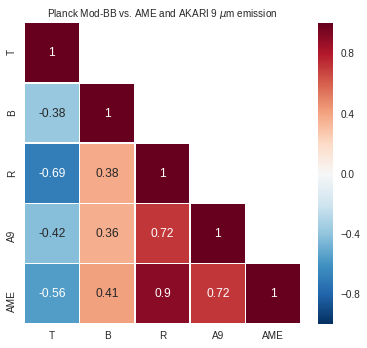

In [15]:
import seaborn as sb
planck_bb_corr = planck_bb_tr.join(phot_tr['A9']).join(planck_mw_tr['AME']).corr(method='spearman')
#bb_corr_drop = bb_corr.drop('AME',axis=0).drop('A9',axis=1)
mask = np.zeros_like(planck_bb_corr.values)
mask[np.triu_indices_from(mask,k=1)] = True



with sb.axes_style("white"):
    
    fig = plt.figure(figsize=(6,5))
    sb.heatmap(
        planck_bb_corr,
        linewidths=.5,
        annot=True,
        mask=mask)
    
    
    fig.show()
    
    plt.title("Planck Mod-BB vs. AME and AKARI 9 $\mu$m emission",fontsize=10)
    
    fig.tight_layout(rect=[0, 0, .9, 1])

    fig.savefig("../Plots/PlanckModBBvsAMEandA9.pdf", bbox_inches='tight')
    


In [16]:
start = -90
stop = 90
step = 1

glat_intervs = np.arange(start,stop,step)

glats = [np.where(np.logical_and(coords['glat']>i, coords['glat']< i+1))  for i in glat_intervs]



In [20]:
bba = planck_bb_tr.join(phot_tr['A9']).join(planck_mw_tr['AME'])

bb_corr_glats = [bba.iloc[i].corr(method='spearman') for i in glats]

#bb_corr_glats_A9 = [bb_corr_glats[i]['A9']]

In [23]:
bb_corr_glats_pn = pd.Panel({i: bb_corr_glats[i] for i in glat_intervs})

In [32]:
bba.columns

Index([u'T', u'B', u'R', u'A9', u'AME'], dtype='object')

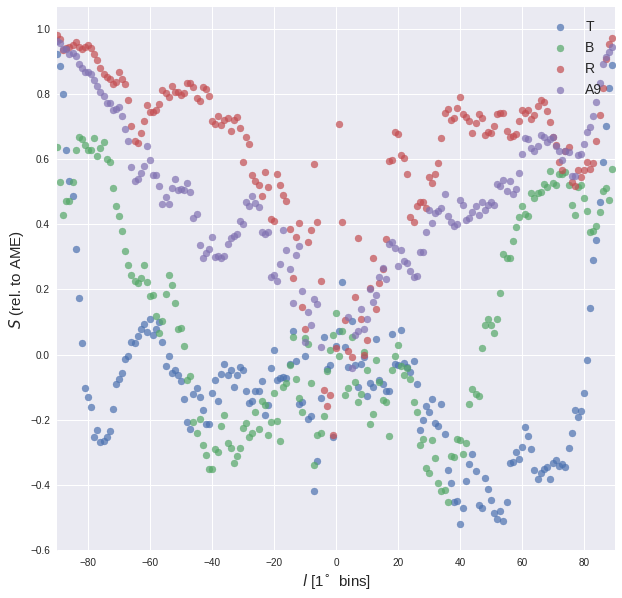

In [46]:
X = glat_intervs

Y = bb_corr_glats_pn.values[:,:,4]

fig = plt.figure(figsize=(10,10))

for i in range(0,4):
    plt.scatter(X,Y[:,i], alpha=0.7, label=bba.columns[i])
plt.legend(loc=1,prop={'size':14},fancybox=True, framealpha=1)
#leg.get_frame().set_alpha(0.5)
plt.xlim(-90,90)
plt.ylabel("$S$ (rel. to AME)", fontsize=15)
plt.xlabel("$l$ [1$^{\circ}$  bins]", fontsize=15)
fig.show()

fig.savefig("../Plots/PlanckModBBvsAMEandA9_byGLAT.pdf", bbox_inches='tight')
#plt.close()
# plt.hist(bb_corr_glats_pn.dropna().values[:,2,0], bins=10, alpha=0.4, label='Beta')
# plt.hist(bb_corr_glats_pn.dropna().values[:,3,0], bins=10, alpha=0.4, label='FIR')
# plt.hist(bb_corr_glats_pn.dropna().values[:,4,0], bins=10, alpha=0.4, label='A9')



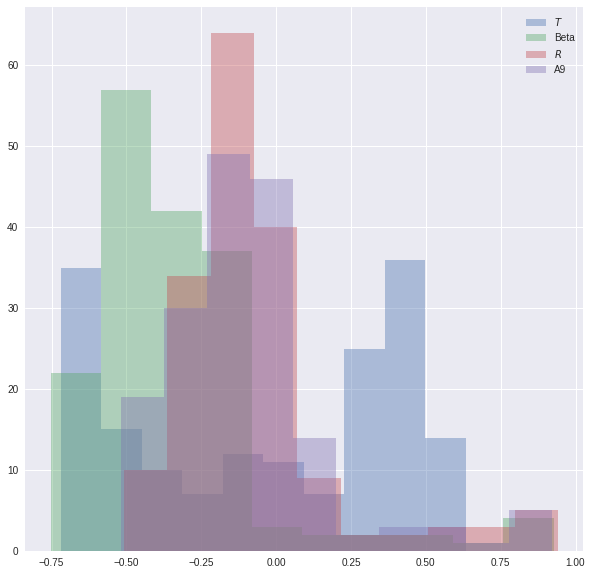

In [49]:
fig = plt.figure(figsize=(10,10))
plt.hist(bb_corr_glats_pn.dropna().values[:,1,0], bins=10, alpha=0.4, label='$T$')
plt.hist(bb_corr_glats_pn.dropna().values[:,2,0], bins=10, alpha=0.4, label='Beta')
plt.hist(bb_corr_glats_pn.dropna().values[:,3,0], bins=10, alpha=0.4, label='$R$')
plt.hist(bb_corr_glats_pn.dropna().values[:,4,0], bins=10, alpha=0.4, label='A9')
plt.legend()

fig.show()

fig.savefig("../Plots/PlanckModBBvsAMEandA9_hist.pdf", bbox_inches='tight')

#plt.plot[bb_corr_glats_pn.values[]])

In [21]:
try:
    p = sb.PairGrid(bb_normd)
    p.map_upper(plt.scatter,alpha=0.1)
    p.map_lower(sb.kdeplot,cmap = "Blues_d")
    p.map_diag(sb.kdeplot, lw=3, legend=False)
except ValueError:  #raised if `y` is empty.
    pass



NameError: name 'bb_normd' is not defined

In [ ]:
try:
    p = sb.PairGrid(bb_normd)
    p.map_upper(plt.scatter)
    p.map_lower(sb.kdeplot,cmap = "Blues_d")
    g.map_diag(sb.kdeplot, lw=3, legend=False)
except ValueError:  #raised if `y` is empty.
    pass



In [ ]:
bba.iloc[glats[40]].corr(method='spearman')
#glats

In [ ]:
labels = [str(bb.columns[i]) for i in range(0,5)]
plt.figure(figsize=(5,5))

for i in range(0,np.size(S_ica_,axis=1)):
#for i in range(1,2):
    plt.subplot(3,2,i+1)
    
    x_ = range(0,np.size(ica.components_,axis=1))
    y_ = ica.components_[i]
    
    #fig, ax = plt.subplots()
    plt.scatter(x_,y_)
    for i, txt in enumerate(labels):
        #print x_[i], y_[i], labels[i]
        plt.annotate(labels[i], (x_[i],y_[i]))
        
    
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.xlim(8,1000)
    #plt.xlabel("Wavelength (microns)       [EV_"+str(i)+"] "+str(round(eig_values[i]/sum(eig_values)*100,2))+"%")
    plt.ylabel("Relative Contribution")
    #plt.show()
    #plt.close()
    
    

In [ ]:
labels = [str(bb.columns[i]) for i in range(0,5)]
plt.figure(figsize=(20,20))

for i in range(0,np.size(S_pca_,axis=1)):
#for i in range(1,2):
    plt.subplot(3,2,i+1)
    
    x_ = range(0,np.size(pca.components_,axis=1))
    y_ = pca.components_[i]
    
    #fig, ax = plt.subplots()
    plt.scatter(x_,y_)
    for i, txt in enumerate(labels):
        #print x_[i], y_[i], labels[i]
        plt.annotate(labels[i], (x_[i],y_[i]))
        
    
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.xlim(8,1000)
    #plt.xlabel("Wavelength (microns)       [EV_"+str(i)+"] "+str(round(eig_values[i]/sum(eig_values)*100,2))+"%")
    plt.ylabel("Relative Contribution")
    #plt.show()
    #plt.close()

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter(S_pca_[:,0], S_pca_[:,1], alpha= 0.1)

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter(S_ica_[:,0], S_ica_[:,1], alpha= 0.1)

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter(S_nmf_[:,0], S_nmf_[:,1], alpha= 0.1)

In [ ]:
model = TSNE(
    n_components=2,
    random_state=42,
    perplexity=50,
    verbose=2
        )
np.set_printoptions(suppress=True)
# for i in range(0,100):
#     try:
#         model.fit_transform(X[::i]) 
#     except:
#         print "Memory Error"

In [ ]:
S_tsne =model.fit_transform(X[::100]) 

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter(S_tsne[:,0],S_tsne[:,1], alpha=0.2)


In [ ]:
model = TSNE(
    n_components=2,
    random_state=42,
    perplexity=25,
    verbose=2
        )
#np.set_printoptions(suppress=True)
# for i in range(0,100):
#     try:
#         model.fit_transform(X[::i]) 
#     except:
#         print "Memory Error"

S_tsne =model.fit_transform(X[::100]) 

plt.figure(figsize=(20,20))
plt.scatter(S_tsne[:,0],S_tsne[:,1], alpha=0.2)

In [ ]:
model = TSNE(
    n_components=2,
    random_state=42,
    perplexity=25,
    verbose=2
        )
#np.set_printoptions(suppress=True)
# for i in range(0,100):
#     try:
#         model.fit_transform(X[::i]) 
#     except:
#         print "Memory Error"

X 

S_tsne =model.fit_transform(X[gcut_1]) 

plt.figure(figsize=(20,20))
plt.scatter(S_tsne[:,0],S_tsne[:,1], alpha=0.2)

In [ ]:
model = TSNE(
    n_components=2,
    random_state=42,
    perplexity=50,
    verbose=2
        )
#np.set_printoptions(suppress=True)
# for i in range(0,100):
#     try:
#         model.fit_transform(X[::i]) 
#     except:
#         print "Memory Error"

S_tsne =model.fit_transform(X[gcut_2]) 

plt.figure(figsize=(20,20))
plt.scatter(S_tsne[:,0],S_tsne[:,1], alpha=0.2)